In [1]:
import pandas as pd
import numpy as np

np.random.seed(4)
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
rawdata = pd.read_excel('excel/明细数据.xlsx')
# 选取2019-2022年的数据
rawdata = rawdata[rawdata['检测时间'].isin(['2019年', '2020年', '2021年', '2022年'])]
rawdata = rawdata[
    ["个体编号", "路线编号", "起讫桩号", "起讫桩号(P)", "检测时间", "路面损坏状况指数PCI", "年平均交通量(辆)",
     "年平均降水量(mm)", "年平均最低温(℃)", "年平均最高温(℃)", "年霜冻期(天)", "季节冻土层厚度(cm)",
     "年平均日照时长(h)"]]
var_list = ["年平均交通量(辆)", "路面损坏状况指数PCI", "年平均降水量(mm)", "年平均最低温(℃)", "年平均最高温(℃)",
            "年霜冻期(天)", "季节冻土层厚度(cm)", "年平均日照时长(h)"]

for var in var_list:
    rawdata[var] = pd.to_numeric(rawdata[var], errors='coerce')

/Users/yy/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
pivot_values = ["年平均交通量(辆)", "路面损坏状况指数PCI", "年平均降水量(mm)", "年平均最低温(℃)", "年平均最高温(℃)"]
trans_years = rawdata.pivot_table(
    index=['个体编号', '路线编号', '起讫桩号', '起讫桩号(P)', '年霜冻期(天)', '季节冻土层厚度(cm)',
           '年平均日照时长(h)'], columns='检测时间', values=pivot_values).reset_index()

In [4]:
rename_list = list(
    map(lambda name_set: name_set[0] + '_' + name_set[1] if name_set[1] != '' else name_set[0], list(trans_years)))
trans_years.columns = rename_list

PCI数据特征：仅有19年和22年的PCI有缺失, 且不存在同时缺失的状况

In [5]:
# 筛选符合PCI值随时间衰减规律的数据行
filtered_df = trans_years[
    ((trans_years['路面损坏状况指数PCI_2019年'] != '') & (trans_years['路面损坏状况指数PCI_2022年'] != '') &
     (trans_years['路面损坏状况指数PCI_2019年'] > trans_years['路面损坏状况指数PCI_2020年']) &
     (trans_years['路面损坏状况指数PCI_2020年'] > trans_years['路面损坏状况指数PCI_2021年']) &
     (trans_years['路面损坏状况指数PCI_2021年'] > trans_years['路面损坏状况指数PCI_2022年']))
    |
    ((trans_years['路面损坏状况指数PCI_2019年'] == '') &
     (trans_years['路面损坏状况指数PCI_2020年'] > trans_years['路面损坏状况指数PCI_2021年']) &
     (trans_years['路面损坏状况指数PCI_2021年'] > trans_years['路面损坏状况指数PCI_2022年']))
    |
    ((trans_years['路面损坏状况指数PCI_2022年'] == '') &
     (trans_years['路面损坏状况指数PCI_2019年'] > trans_years['路面损坏状况指数PCI_2020年']) &
     (trans_years['路面损坏状况指数PCI_2020年'] > trans_years['路面损坏状况指数PCI_2021年']))
    ]
filtered_df.to_excel('excel/temp.xlsx')

In [6]:
# 指定要计算均值的列, 这里只需要计算最低温, 最高温和降水量这三个因素的均值
columns_lowtemp = list(filter(lambda element: "最低温" in element, rename_list))
columns_hightemp = list(filter(lambda element: "最高温" in element, rename_list))
columns_precip = list(filter(lambda element: "降水量" in element, rename_list))
# 计算指定列的均值
filtered_df['avg_lowtemp'] = filtered_df[columns_lowtemp].mean(axis=1)
filtered_df['avg_hightemp'] = filtered_df[columns_hightemp].mean(axis=1)
filtered_df['avg_precip'] = filtered_df[columns_precip].mean(axis=1)
# 对2019年的交通量数据进行均值填补
filtered_df['fill_mean_19'] = filtered_df[
    ['年平均交通量(辆)_2020年', '年平均交通量(辆)_2021年', '年平均交通量(辆)_2022年']].mean(axis=1)
filtered_df['年平均交通量(辆)_2019年'] = filtered_df['年平均交通量(辆)_2019年'].fillna(filtered_df['fill_mean_19'])
# 对2020年的交通量数据进行均值填补
filtered_df['fill_mean_20'] = filtered_df[
    ['年平均交通量(辆)_2019年', '年平均交通量(辆)_2021年', '年平均交通量(辆)_2022年']].mean(axis=1)
filtered_df['年平均交通量(辆)_2020年'] = filtered_df['年平均交通量(辆)_2020年'].fillna(filtered_df['fill_mean_20'])
# 填补完毕删去此过程产生的列数据
filtered_df = filtered_df.drop(['fill_mean_19', 'fill_mean_20'], axis=1)
# 将交通量异常值删去, 交通量超过10万的路段G312 2374~2380.745共7个检测路段, 且仅收集到该路段21年和22年的交通量
filtered_df = filtered_df.drop(filtered_df[filtered_df['年平均交通量(辆)_2021年'] > 100000].index)
# filtered_df.to_excel('excel/temp.xlsx')
# 将日照时长异常值删去
filtered_df = filtered_df.drop(filtered_df[filtered_df['年平均日照时长(h)'] < 10].index)
filtered_df.to_excel('excel/temp.xlsx')
# filtered_df

/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' 

根据肘部法得到的最佳聚类数量: 6


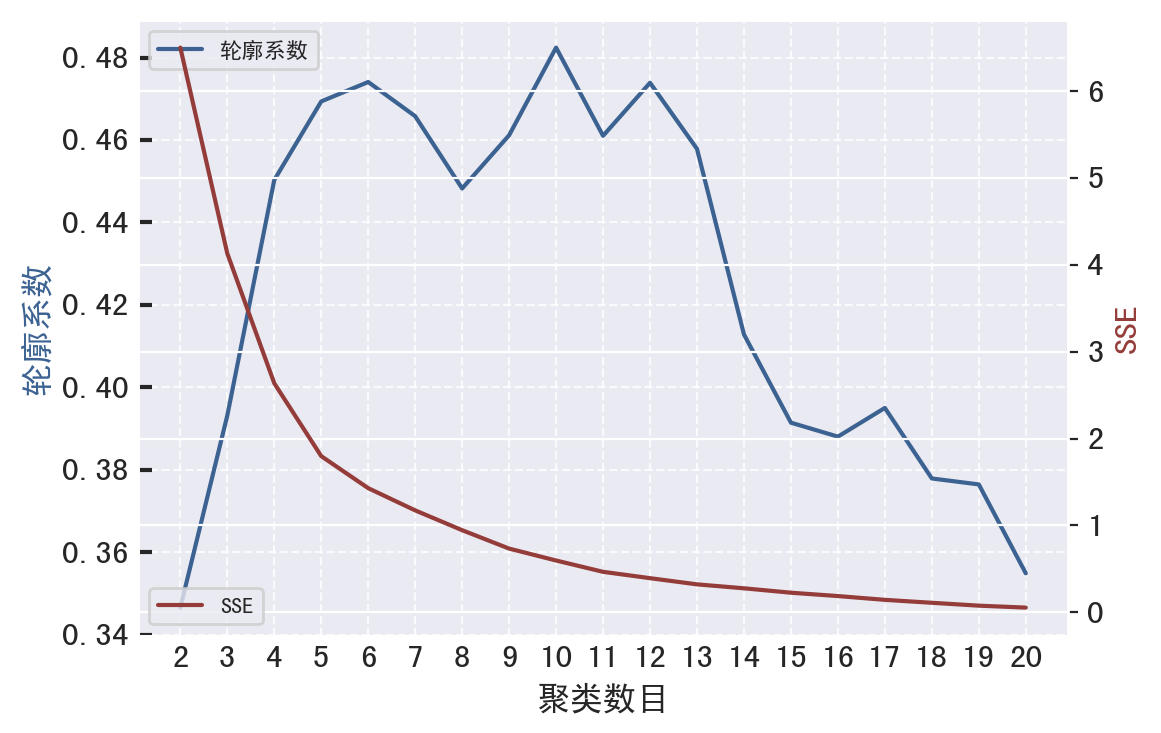

In [7]:
# 确定聚类元素, 归一化数据
envir_features = ["年霜冻期(天)", "季节冻土层厚度(cm)", "年平均日照时长(h)", "avg_lowtemp", "avg_hightemp",
                  "avg_precip"]
features_ds = filtered_df[envir_features]
features_ds_unique = features_ds.drop_duplicates(subset=None, keep='first', inplace=False)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features_ds_unique)
silhouette_coefficients = []
sse = []
MAX_CLUSTER = 21
num_clusters = list(range(2, MAX_CLUSTER))
for k in range(2, MAX_CLUSTER):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_features)
    s_score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(s_score)
    sse.append(kmeans.inertia_)
kl = KneeLocator(num_clusters, sse, curve="convex", direction="decreasing")
print("根据肘部法得到的最佳聚类数量: %d" % kl.elbow)
# 设置全局字体为Times New Roman，字体大小为18，轴宽度为2
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置图例标题大小
plt.rcParams['legend.title_fontsize'] = 9
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=200)
colors = ["#3b6291", "#943c39"]
legend = ['轮廓系数', 'SSE']
ax1.plot(num_clusters, silhouette_coefficients, color=colors[0], label=legend[0])
ax1.set_xlabel('聚类数目')
ax1.set_ylabel('轮廓系数', color=colors[0])
plt.xticks(num_clusters)
ax2 = ax1.twinx()
ax2.plot(num_clusters, sse, color=colors[1], label=legend[1])
ax2.set_ylabel('SSE', color=colors[1])
# 修改刻度属性
ax1.tick_params(which='major', length=5, width=1.5, direction='in')
ax1.tick_params(which='minor', length=3, width=1, direction='in')
# 添加网格
ax1.grid(which='major', ls='--', alpha=.8, lw=.8)
# 添加图例
ax1.legend(fontsize=8, loc='upper left', title="")
ax2.legend(fontsize=8, loc='lower left', title="")
# 添加文本信息
ax1.set_title("", fontsize=14, pad=10)
# plt.savefig('image/kmeans.png', dpi=300)
plt.show()

## 设置聚类数目

In [8]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_features)
result = kmeans.predict(scaled_features)
features_ds_unique["cluster"] = result
cluster_data = pd.merge(filtered_df, features_ds_unique, on=envir_features, how='left')
cluster_data = cluster_data.sort_values(by=['cluster', '路线编号', '起讫桩号', '起讫桩号(P)'])
cluster_data = cluster_data.drop('个体编号', axis=1)
cluster_data = cluster_data.reset_index(drop=True)
cluster_data.to_excel("excel/cluster.xlsx")

/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# 数据处理1：取中位数

## 2019年--2020年 ---- 

In [9]:
median_20_df = cluster_data[
    ['cluster', '路线编号', '起讫桩号', '起讫桩号(P)', '年平均交通量(辆)_2020年', '路面损坏状况指数PCI_2019年','路面损坏状况指数PCI_2020年']]
median_20_df['diff'] = median_20_df['路面损坏状况指数PCI_2019年'] - median_20_df['路面损坏状况指数PCI_2020年']
median_df = median_20_df.sort_values(by=['cluster', '路线编号', '起讫桩号', 'diff'])


In [10]:
median_df

,cluster,路线编号,起讫桩号,起讫桩号(P),年平均交通量(辆)_2020年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,diff
0,0,G212,603~613,611~612,2584.0,95.14,93.93,1.21
1,0,G212,630.146~636,634~635,2584.0,94.36,92.30,2.06
2,0,G212,637~646,637~638,2560.0,98.36,97.02,1.34
3,0,G345,2337~2351,2347~2348,3146.0,99.53,98.58,0.95
5,0,G345,2337~2351,2350~2351,3146.0,96.82,95.14,1.68
...,...,...,...,...,...,...,...,...
136,2,G568,230~238,234~235,8102.0,91.63,90.26,1.37
137,2,G568,230~238,235~236,8102.0,91.12,88.16,2.96
135,2,G568,230~238,233~234,8102.0,92.90,89.59,3.31
134,2,G568,230~238,231~232,8102.0,91.63,87.24,4.39


In [12]:
# 自定义聚合函数，计算中位数并选择中间位置的两个样本
def custom_agg_middle_samples(x):
    median_var2 = x['diff'].median()
    if len(x) % 2 == 0:  # 如果样本数量为偶数
        middle_samples = x.iloc[(x['diff'] - median_var2).abs().argsort()[:2]]
    else:  # 如果样本数量为奇数
        middle_samples = x.iloc[(x['diff'] - median_var2).abs().argsort()[:1]]
    return middle_samples

In [13]:
# 使用 groupby 和自定义聚合函数来处理数据
# 相同交通量的路段如果有偶数条，那就留下最中间那两条（后续在平均）；相同交通量的路段如果有奇数条，那就留下最中间那一条（后续在平均的时候还是原样）；
result_df = median_df.groupby(['cluster', '年平均交通量(辆)_2020年']).apply(custom_agg_middle_samples).reset_index(drop=True)
result_df

,cluster,路线编号,起讫桩号,起讫桩号(P),年平均交通量(辆)_2020年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,diff
0,0,G212,637~646,637~638,2560.0,98.36,97.02,1.34
1,0,G212,603~613,611~612,2584.0,95.14,93.93,1.21
2,0,G212,630.146~636,634~635,2584.0,94.36,92.30,2.06
3,0,G345,2337~2351,2350~2351,3146.0,96.82,95.14,1.68
4,1,G309,1995.606~2001,1995.606~1997,717.0,93.08,92.43,0.65
5,1,G309,1995.606~2001,2000~2001,717.0,90.76,90.00,0.76
6,1,G309,2057~2065,2062~2063,1177.0,98.14,96.17,1.97
7,1,G109,1650.508~1657,1655~1656,2926.0,91.60,90.12,1.48
8,1,G213,316~320,318~319,3028.0,86.67,85.11,1.56
9,1,G109,1635~1640,1639~1640,3213.0,91.20,89.50,1.70


In [12]:
# 平均
mean_pci = result_df.groupby(['cluster', '年平均交通量(辆)_2020年']).mean(
    ['路面损坏状况指数PCI_2019年', '路面损坏状况指数PCI_2020年', 'diff']).reset_index()
median_19_20 = mean_pci.rename(columns={'年平均交通量(辆)_2020年': 'traffic', '路面损坏状况指数PCI_2019年': 'PCI_0','路面损坏状况指数PCI_2020年': 'PCI_contemp'})
median_19_20['type'] = '2019-2020(median)'
median_19_20 = median_19_20[
    ['cluster', 'type', 'traffic', 'PCI_0', 'PCI_contemp', 'diff']]
# median_19_20.to_excel("excel/temp.xlsx")

In [13]:
median_19_20

,cluster,type,traffic,PCI_0,PCI_contemp,diff
0,0,2019-2020(median),2560.0,98.360,97.020,1.340
1,0,2019-2020(median),2584.0,94.750,93.115,1.635
2,0,2019-2020(median),3146.0,96.820,95.140,1.680
3,1,2019-2020(median),717.0,91.920,91.215,0.705
4,1,2019-2020(median),1177.0,98.140,96.170,1.970
5,1,2019-2020(median),2926.0,91.600,90.120,1.480
6,1,2019-2020(median),3028.0,86.670,85.110,1.560
7,1,2019-2020(median),3213.0,91.200,89.500,1.700
8,1,2019-2020(median),6693.0,97.950,94.005,3.945
9,1,2019-2020(median),9341.0,90.480,89.520,0.960


## 2019年--2021年

In [71]:
median_21_df = cluster_data[
    ['cluster', '路线编号', '起讫桩号', '起讫桩号(P)', '年平均交通量(辆)_2020年', '年平均交通量(辆)_2021年',
     '路面损坏状况指数PCI_2019年', '路面损坏状况指数PCI_2021年']]
median_21_df['diff'] = median_21_df['路面损坏状况指数PCI_2019年'] - median_21_df['路面损坏状况指数PCI_2021年']
median_21_df['traffic'] = median_21_df['年平均交通量(辆)_2020年'] + median_21_df['年平均交通量(辆)_2021年']
median_df = median_21_df.sort_values(by=['cluster', '路线编号', '起讫桩号', 'diff'])
result_df = median_df.groupby(['cluster', 'traffic']).apply(custom_agg_middle_samples).reset_index(drop=True)
mean_pci = result_df.groupby(['cluster', 'traffic']).mean(
    ['路面损坏状况指数PCI_2019年', '路面损坏状况指数PCI_2021年', 'diff']).reset_index()
median_19_21 = mean_pci.rename(
    columns={'路面损坏状况指数PCI_2019年': 'PCI_0', '路面损坏状况指数PCI_2021年': 'PCI_contemp'})
median_19_21['type'] = '2019-2021(median)'
median_19_21 = median_19_21[
    ['cluster', 'type', 'traffic', 'PCI_0', 'PCI_contemp', 'diff']]
# median_19_21.to_excel("excel/temp.xlsx")

# 数据处理2：取平均值

## 2019年--2020年

In [72]:
avg_20_df = cluster_data[
    ['cluster', '路线编号', '起讫桩号', '起讫桩号(P)', '年平均交通量(辆)_2020年', '路面损坏状况指数PCI_2019年',
     '路面损坏状况指数PCI_2020年']]
avg_19_20 = avg_20_df.groupby(['cluster', '年平均交通量(辆)_2020年']).mean(
    ['路面损坏状况指数PCI_2019年', '路面损坏状况指数PCI_2020年']).reset_index()
avg_19_20['type'] = '2019-2020(avg)'
avg_19_20['diff'] = avg_19_20['路面损坏状况指数PCI_2019年'] - avg_19_20['路面损坏状况指数PCI_2020年']
avg_19_20 = avg_19_20.rename(columns={'年平均交通量(辆)_2020年': 'traffic', '路面损坏状况指数PCI_2019年': 'PCI_0',
                                      '路面损坏状况指数PCI_2020年': 'PCI_contemp'})
avg_19_20 = avg_19_20[
    ['cluster', 'type', 'traffic', 'PCI_0', 'PCI_contemp', 'diff']]
# avg_19_20.to_excel("excel/temp.xlsx")

## 2019年-2021年

In [73]:
avg_21_df = cluster_data[
    ['cluster', '路线编号', '起讫桩号', '起讫桩号(P)', '年平均交通量(辆)_2020年', '年平均交通量(辆)_2021年',
     '路面损坏状况指数PCI_2019年',
     '路面损坏状况指数PCI_2021年']]
avg_21_df['traffic'] = avg_21_df['年平均交通量(辆)_2020年'] + avg_21_df['年平均交通量(辆)_2021年']
avg_19_21 = avg_21_df.groupby(['cluster', 'traffic']).mean(
    ['路面损坏状况指数PCI_2019年', '路面损坏状况指数PCI_2021年']).reset_index()
avg_19_21['type'] = '2019-2021(avg)'
avg_19_21['diff'] = avg_19_21['路面损坏状况指数PCI_2019年'] - avg_19_21['路面损坏状况指数PCI_2021年']
avg_19_21 = avg_19_21.rename(
    columns={'路面损坏状况指数PCI_2019年': 'PCI_0', '路面损坏状况指数PCI_2021年': 'PCI_contemp'})
avg_19_21 = avg_19_21[
    ['cluster', 'type', 'traffic', 'PCI_0', 'PCI_contemp', 'diff']]
# avg_19_21.to_excel("excel/temp.xlsx")

## 测试数据：2021年–-2022年

In [14]:
test_22_df = cluster_data[
    ['cluster', '路线编号', '起讫桩号', '起讫桩号(P)', '年平均交通量(辆)_2022年', '路面损坏状况指数PCI_2021年',
     '路面损坏状况指数PCI_2022年']]
test_22_df['diff'] = test_22_df['路面损坏状况指数PCI_2021年'] - test_22_df['路面损坏状况指数PCI_2022年']

test_21_22 = test_22_df.rename(columns={'年平均交通量(辆)_2022年': 'traffic', '路面损坏状况指数PCI_2021年': 'PCI_0',
                                        '路面损坏状况指数PCI_2022年': 'PCI_contemp'})
test_21_22['type'] = '2021-2022'
test_21_22 = test_21_22[
    ['cluster', 'type', 'traffic', 'PCI_0', 'PCI_contemp', 'diff']]
# test_21_22.to_excel("excel/temp.xlsx")

In [15]:
test_21_22

,cluster,type,traffic,PCI_0,PCI_contemp,diff
0,0,2021-2022,3875.0,93.07,92.06,1.01
1,0,2021-2022,3763.0,91.72,91.69,0.03
2,0,2021-2022,3856.0,94.12,93.55,0.57
3,0,2021-2022,4380.0,98.26,95.89,2.37
4,0,2021-2022,4380.0,93.67,91.28,2.39
...,...,...,...,...,...,...
133,2,2021-2022,8493.0,84.28,79.84,4.44
134,2,2021-2022,8493.0,84.98,78.44,6.54
135,2,2021-2022,8493.0,83.16,82.76,0.40
136,2,2021-2022,8493.0,87.14,81.21,5.93


## 合并处理
### 删除一些异常数据：交通量大的, 差值反而小；交通量小的，差值反而大；差值过大的

In [75]:
intack = pd.concat([median_19_20, median_19_21, avg_19_20, avg_19_21, test_21_22], axis=0, join='inner',
                   ignore_index=True)
intack.to_excel("excel/temp.xlsx")
intack = intack.drop(intack[
                         (intack['traffic'] == 9725) |
                         (intack['traffic'] == 2008) |
                         (intack['traffic'] == 31728)].index) # 横坐标diff、纵坐标log_traffic
intack['traffic'] = intack['traffic'] * 365
intack['log_traffic'] = np.log(intack['traffic'])
intack['cluster'] = intack['cluster'] + 1

# 拆分数据：
## type为2019-2020和2019-2021的数据作为训练集
## type为2021-2022的数据作为测试集

In [76]:
median_train = intack[intack['type'].str.contains("median")].reset_index(drop=True)
median_train.to_excel("excel/median_trainDs.xlsx")
avg_train = intack[intack['type'].str.contains("avg")].reset_index(drop=True)
avg_train.to_excel("excel/avg_trainDs.xlsx")
test = intack[intack['type'].str.contains("2022")].reset_index(drop=True)
test.to_excel("excel/testDs.xlsx")